<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/4_Transfer_Learning/2_FineTuning.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Fine-Tuning



En clases anteriores, discutimos cómo entrenar modelos en el dataset de entrenamiento Fashion-MNIST con solo 60000 imágenes. También describimos ImageNet, el dataset de imágenes a gran escala más utilizado en el mundo académico, que tiene más de 10 millones de imágenes y 1000 clases. Sin embargo, el tamaño de los dataset que solemos encontrar está entre medio de ambos.

Supongamos que queremos reconocer diferentes tipos de sillas a partir de imágenes y luego recomendar enlaces de compra a los usuarios. Un método posible es identificar primero 100 sillas comunes, tomar 1000 imágenes de diferentes ángulos para cada silla y luego entrenar un modelo de clasificación en el dataset de imágenes recopiladas. Aunque este dataset de sillas puede ser más grande que el dataset de Fashion-MNIST, la cantidad de ejemplos sigue siendo menos de una décima parte de la de ImageNet. Esto puede provocar el sobreajuste de modelos complicados que son adecuados para ImageNet en este dataset de silla. Además, debido a la cantidad limitada de ejemplos de entrenamiento, es posible que la precisión del modelo entrenado no cumpla con los requisitos prácticos.

Para abordar los problemas anteriores, una solución obvia es recopilar más datos. Sin embargo, recopilar y etiquetar datos puede requerir mucho tiempo y dinero. Por ejemplo, para recopilar el dataset de ImageNet, los investigadores han gastado millones de dólares en fondos de investigación. Aunque el costo actual de recopilación de datos se ha reducido significativamente, este costo aún no se puede ignorar.

Otra solución es aplicar el aprendizaje por transferencia (transfer learning) para transferir el conocimiento aprendido del dataset de origen al dataset de destino. Por ejemplo, aunque la mayoría de las imágenes en el dataset de ImageNet no tienen nada que ver con sillas, el modelo entrenado en este dataset puede extraer características de imagen más generales, lo que puede ayudar a identificar bordes, texturas, formas y composición de objetos. Estas características similares también pueden ser efectivas para reconocer sillas.

## Pasos


En esta sección, presentaremos una técnica común en el aprendizaje por transferencia: ***fine tuning*** (ajuste fino). Como se muestra en la figura, el fine tuning consta de los siguientes cuatro pasos:

![Imgur](https://i.imgur.com/rMeDaRy.png)


1. Entrene previamente un modelo de red neuronal, es decir, el ***modelo de origen***, en un conjunto de datos de origen (por ejemplo, el conjunto de datos de ImageNet).
1. Cree un nuevo modelo de red neuronal, es decir, el ***modelo de destino***. Este **copia todo el diseño y los parámetros del modelo de origen excepto la capa de salida**. Suponemos que estos parámetros del modelo contienen el conocimiento aprendido del conjunto de datos de origen y este conocimiento también será aplicable al conjunto de datos de destino. También suponemos que la capa de salida del modelo de origen está estrechamente relacionada con las etiquetas del conjunto de datos de origen; por lo tanto, no se utiliza en el modelo de destino.
1. Agregue una capa de salida al modelo de destino, cuyo número de salidas sea el número de clases en el conjunto de datos de destino. Luego inicialice aleatoriamente los parámetros del modelo de esta capa.
1. Entrene el modelo de destino en el conjunto de datos de destino, como un conjunto de datos de sillas. La capa de salida se entrenará desde cero, mientras que los parámetros de todas las demás capas se ajustarán en función de los parámetros del modelo de origen.



Cuando el conjunto de datos de destino es mucho más pequeño que el conjunto de datos de origen, el fine tuning ayuda a mejorar la capacidad de generalización de los modelos.


## Reconocimiento de Hot Dogs

Demostremos el ajuste fino a través de un caso concreto: el reconocimiento de hot dogs. Haremos fine-tuning sobre  un modelo de ResNet, que se entrenó previamente en el conjunto de datos de ImageNet. Este fine tuning se hará con un pequeño conjunto de datos que consta de miles de imágenes con y sin hot dogs. Usaremos el modelo ajustado para reconocer hot dogs a partir de imágenes.





In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn


### Lectura del dataset

El dataset de hot dogs que usamos se tomó de imágenes en línea. Este conjunto de datos consta de 1400 imágenes de clase positiva que contienen hot dogs y otras tantas imágenes de clase negativa que contienen otros alimentos. Se utilizan 1000 imágenes de ambas clases para entrenamiento y el resto para pruebas.

Después de descomprimir el conjunto de datos descargado, obtenemos dos carpetas `hotdog/train` y `hotdog/test`. Ambas carpetas tienen subcarpetas `hotdog` y `not-hotdog`, cualquiera de las cuales contiene imágenes de la clase correspondiente.

In [2]:
import requests
import zipfile
import tarfile
url = "http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip"
os.makedirs("data", exist_ok=True)
fname = os.path.join("data", url.split('/')[-1])
print(f'Downloading {fname} from {url}...')
r = requests.get(url, stream=True, verify=True)
with open(fname, 'wb') as f:
    f.write(r.content)
base_dir = os.path.dirname(fname)
data_dir, ext = os.path.splitext(fname)
if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
else:
    assert False, 'Only zip/tar files can be extracted.'
fp.extractall(base_dir)

Creamos dos instancias para leer todos los archivos de imagen en el conjunto de datos de entrenamiento y prueba, respectivamente.


In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

Los primeros 8 ejemplos positivos y las últimas 8 imágenes negativas se muestran a continuación. Como puede ver, las imágenes varían en tamaño y relación de aspecto.


In [4]:
from matplotlib import pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

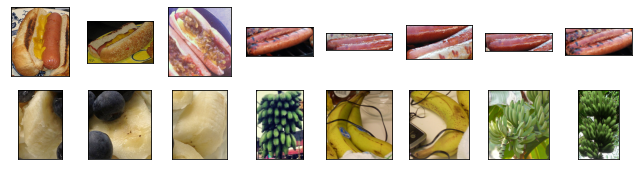

In [5]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

### Data Augmentation

Durante el entrenamiento, primero recortamos de la imagen un área aleatoria de tamaño aleatorio y relación de aspecto aleatoria, y luego escalamos esta área a una imagen de entrada de $224 \times 224$. Durante las pruebas, escalamos tanto el alto como el ancho de una imagen a 256 píxeles y luego recortamos un área central de $224 \times 224$ como entrada. Además, para los tres canales de color RGB (rojo, verde y azul) *estandarizamos* sus valores canal por canal. Concretamente, el valor medio de un canal se resta de cada valor de ese canal y luego el resultado se divide por la desviación estándar de ese canal.

In [6]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Definición e inicialización del modelo

Usamos como modelo de origen a ResNet-18, que se entrenó previamente en el conjunto de datos de ImageNet. Aquí, especificamos `pretrained=True` para descargar automáticamente los parámetros del modelo previamente entrenado. Si este modelo se utiliza por primera vez, se requiere conexión a Internet para la descarga.

In [7]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

La instancia del modelo de origen previamente entrenada contiene varias capas de características y una capa de salida `fc`. El objetivo principal de esta división es facilitar el ajuste fino de los parámetros del modelo de todas las capas excepto la capa de salida. El atributo `fc` del modelo de origen se proporciona a continuación.


In [8]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

Como se trata de una capa densa, transforma los resultados de la capa de avg-pooling global final de ResNet en 1000 probabilidades de clase del conjunto de datos de ImageNet. Luego construimos una nueva red neuronal como modelo objetivo. Se define de la misma manera que el modelo de origen previamente entrenado, excepto que su número de salidas en la capa final se establece en el número de clases en el conjunto de datos de destino (en lugar de 1000).

En el siguiente código, los parámetros del modelo antes de la capa de salida de la instancia del modelo de destino finetune_net se inicializan en los parámetros del modelo de las capas correspondientes del modelo de origen. Dado que **estos parámetros del modelo se obtuvieron mediante entrenamiento previo en ImageNet**, son efectivos. Por lo tanto, solo podemos usar una pequeña tasa de aprendizaje para ajustar dichos parámetros previamente entrenados. Por el contrario, los parámetros del modelo en la capa de salida se inicializan aleatoriamente y generalmente requieren una mayor tasa de aprendizaje para aprender desde cero. Dejando que la tasa de aprendizaje base sea η, se utilizará una tasa de aprendizaje de 10η para iterar los parámetros del modelo en la capa de salida.


In [9]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

### Haciendo el Fine-Tuning del modelo.

Primero, definimos una función de entrenamiento `train_fine_tuning` para que pueda llamarse varias veces.


In [10]:
# Si `param_group=True`, los parámetros del modelo en la capa de salida se
# actualizarán usando una tasa de aprendizaje diez veces mayor
def train_fine_tuning(model, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in model.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': model.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    model.to(device)
    for epoch in range(num_epochs):
      L = 0.0
      N = 0
      Acc = 0.0
      for X, y in train_iter:
          X, y = X.to(device), y.to(device)
          l = loss(model(X),y)
          trainer.zero_grad()
          l.sum().backward()
          trainer.step()
          L += l.sum()
          N += l.numel()
      print(f'epoch {epoch + 1}, loss {(L/N):f}')

Establecemos la tasa de aprendizaje base en un valor pequeño para *afinar* los parámetros del modelo obtenidos a través del entrenamiento previo. Según la configuración anterior, entrenaremos los parámetros de la capa de salida del modelo de destino desde cero utilizando una tasa de aprendizaje diez veces mayor.


In [11]:
train_fine_tuning(finetune_net, 5e-5)

epoch 1, loss 1.913213
epoch 2, loss 0.295214
epoch 3, loss 0.268814
epoch 4, loss 0.193790
epoch 5, loss 0.189346


A modo de comparación, definimos un modelo idéntico, pero inicializamos todos sus parámetros de modelo a valores aleatorios. Dado que todo el modelo debe entrenarse desde cero, podemos usar una tasa de aprendizaje mayor.


In [12]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

epoch 1, loss 2.117215
epoch 2, loss 0.567417
epoch 3, loss 0.509597
epoch 4, loss 0.409415
epoch 5, loss 0.394479


Como podemos ver, el modelo ajustado tiende a funcionar mejor para la misma época porque los valores iniciales de sus parámetros son más efectivos.